# Try fitting 2-tone spectrum:
## Flow:
    Package used
    Load data and check detail
    Fitting:
        *linecut
        *full spectrum
    Constrain and still not well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
import os
from scipy.optimize import curve_fit as CF

In [2]:
# something = Data.something
class Data_pack():
    def __init__(self, inp_data):
        self.data = inp_data
        self.freq = inp_data[:,0,0]
        self.yoko = inp_data[0,1,:]
        self.I = inp_data[:,2,:]
        self.Q = inp_data[:,3,:]
        self.IQ = self.I + 1j*self.Q
        self.phase = np.unwrap(np.angle(self.IQ))
        self.mag = np.abs(self.IQ)

In [3]:
# load files to "data_list" and record file name in "files"
root="C:\\Users\\user\\Desktop\\code\\two_tone_spectra\\two_tone_data\\"
files = glob(os.path.join(root, "*/*.hdf5"))
data_list = []
for i in range(len(files)):
    # extract data
    data_list.append(h5py.File(files[i], "r")["Data"]["Data"])

<ipython-input-4-05cd75e8c6b7>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(idx)


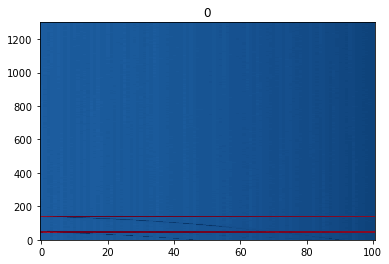

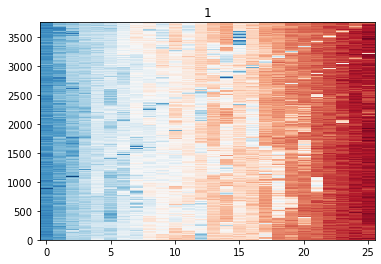

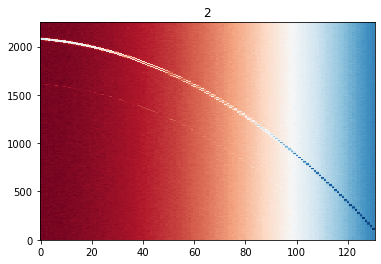

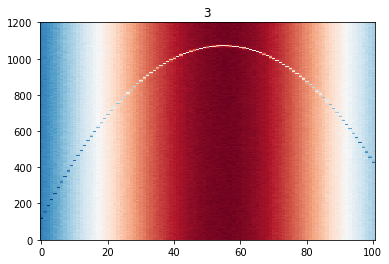

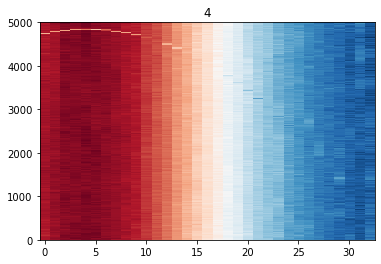

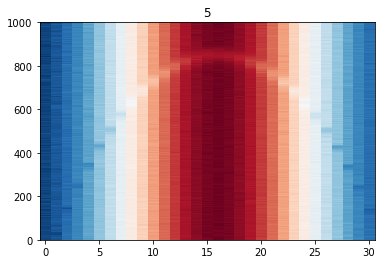

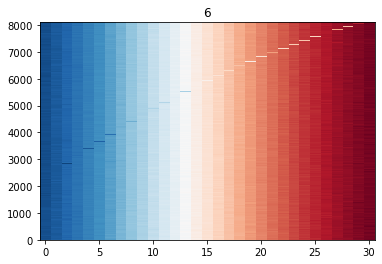

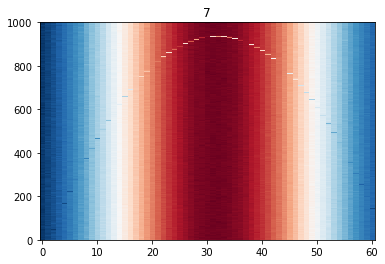

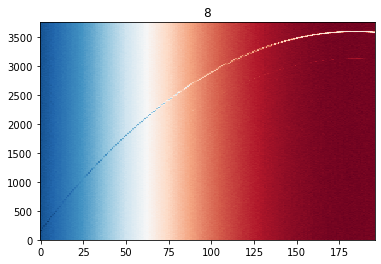

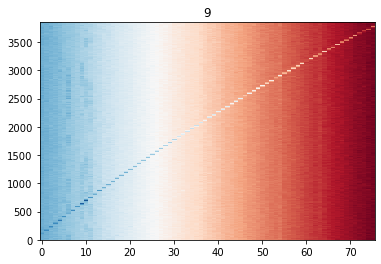

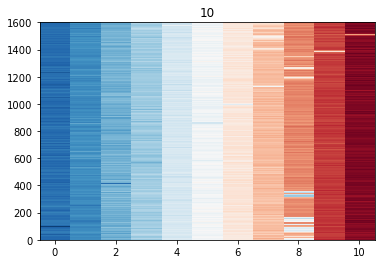

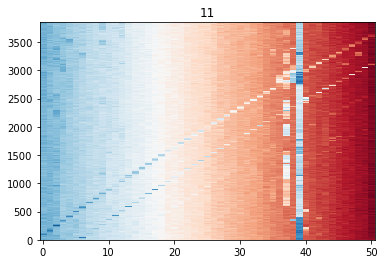

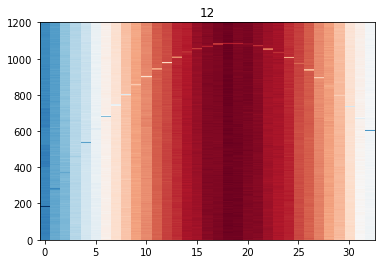

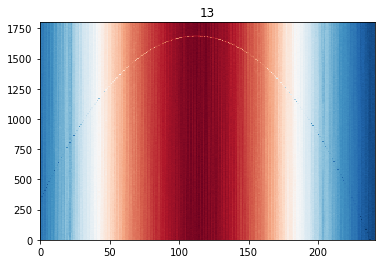

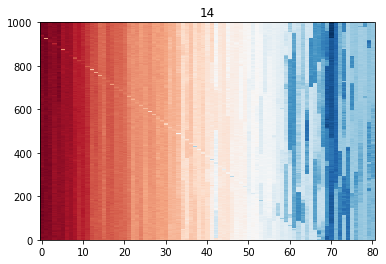

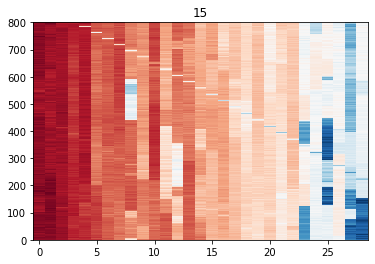

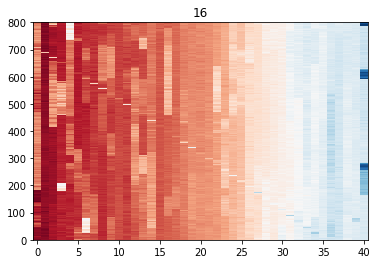

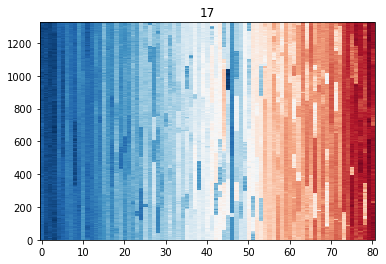

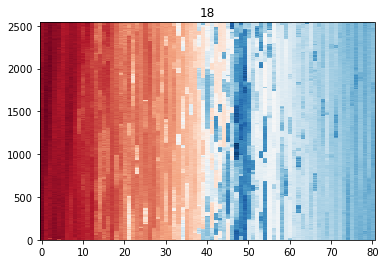

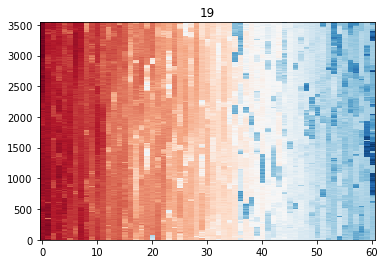

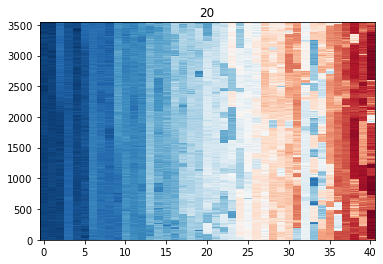

In [4]:
# Check spectrum of loaded data(recognizable)
for idx, data in enumerate(data_list[:]):
    plt.figure(idx)
    plt.title(f"{idx}")
    plt.imshow(Data_pack(data).phase, cmap="RdBu_r", aspect="auto", interpolation="None", origin="lower")

# fitting tried: [2,3,4,5,6,7,8,9,12,13]

In [17]:
# Select and packup one of the 2-tone data
"""
Suppose I should run for loop instead of evaluating one by one. But there are
some defects during the fitting process, so I rather do it one by one.
"""
test_idx = 2
two_tone_spectrum = Data_pack(data_list[test_idx])
# Check:
print("file name       : " + files[test_idx].split("\\")[-1],
      "\nRaw data shape  : " + f"{np.shape(two_tone_spectrum.data)}",
      "\nPhase data shape: " + f"{np.shape(two_tone_spectrum.phase)}" )


file name       : two_tone_sweep_flux_tranmon001_11.hdf5 
Raw data shape  : (2251, 4, 131) 
Phase data shape: (2251, 131)


In [18]:
# Data:
phase = two_tone_spectrum.phase
mag   = two_tone_spectrum.mag
freq  = two_tone_spectrum.freq * 1e-6 # scaling to MHz
yoko  = two_tone_spectrum.yoko * 1e+3 # scaling to mA
"""
Scaling data to adequate value. If the true value of the parameters is too large or
too small, the fitting algorithm probably fails(converging to not even a local minima).
"""

'\nScaling data to adequate value. If the true value of the parameters is too large or\ntoo small, the fitting algorithm probably fails(converging to not even a local minima).\n'

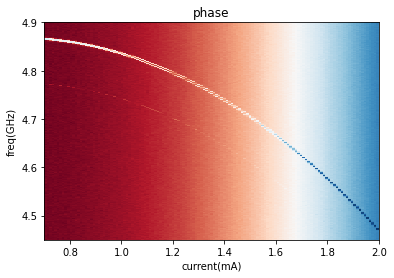

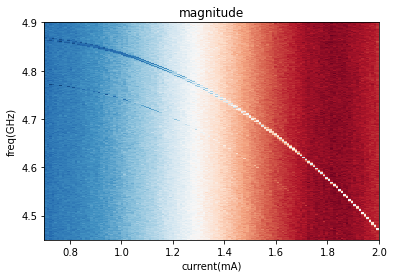

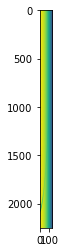

In [19]:
# Check sweep-flux spectrum of phase and magnitude

# extent setting for imshow
extent = [min(yoko),max(yoko),min(freq)*1e-3,max(freq)*1e-3]

plt.figure(1)
plt.title("phase")
plt.xlabel("current(mA)")
plt.ylabel("freq(GHz)")
plt.imshow(phase, cmap="RdBu_r", aspect="auto", interpolation="None", origin="lower", extent=extent)

plt.figure(2)
plt.title("magnitude")
plt.xlabel("current(mA)")
plt.ylabel("freq(GHz)")
plt.imshow(mag  , cmap="RdBu_r", aspect="auto", interpolation="None", origin="lower", extent=extent)
# p.s: the setting of aspect and origin is noticable.

plt.figure(3)
plt.imshow(phase)

In [20]:
# Fitting fcns, "gaussian" for linecuts (lorentzian?), and "curve"(~cos^0.5) for full spectrum.
gaussian   = lambda f, a,b,c,d: a*np.exp(b*(f-c)**2)+ d              # main variable: frequency
lorantzian = lambda f, a,b,c,d: a/(1+(f-c)**2/b**2) + d              # main variable: frequency
curve      = lambda I, a,b,c,d: a*(np.abs(np.cos(b*(I-c))))**0.5 + d # main variable: current

# f_q => f_01
def f_q_fitter(line_cut, freq, fit_width=len(freq)//20, plot_detail=False):
    """Find fitting interval, fitting fails for full line_cut and gives constant line."""
    peak_guess = np.where(line_cut==min(line_cut))[0] # min => dep of line_cut shows f_q
    peak_guess = int(peak_guess)
    # Adjust fitting interval if close to bound; start, end: index of interval
    if peak_guess <= fit_width:
        start, end = 0, peak_guess+fit_width
    elif peak_guess >= len(line_cut)-fit_width:
        start, end = peak_guess-fit_width, len(line_cut)
    else:
        start, end = peak_guess-fit_width, peak_guess+fit_width

    # fitting guess for linecut
    ## a ~ min-max, b ~ width, c ~ f_q, d ~ max
    ## width of gaussian: 1~10MHz; note that if the inital guess of b is too small,
    ## it fits part of the fringe instaed of full lorentzian*cos^2.
    p0 = [min(line_cut)-max(line_cut), 10, freq[peak_guess], max(line_cut)]
    param, _ = CF(lorantzian, freq[start: end], line_cut[start: end], p0=p0, maxfev=10000)
    # We want f_q~param[3] only; find nearest f_q measured.
    freq_idx = np.where( np.min(np.abs(freq-param[2])) == np.abs(freq-param[2]) )[0]
    f_q = freq[int(freq_idx)]
    width = param[1]
    
    # Plot fitting detail if needed
    if plot_detail==True:
        plt.title("linecut")
        plt.xlabel("freq(MHz)")
        plt.ylabel("phase")
        plt.plot(freq[start: end], line_cut[start: end], "k.")
        plt.plot(freq[start: end], lorantzian(freq[start: end], *param))
    
    return f_q, width
   

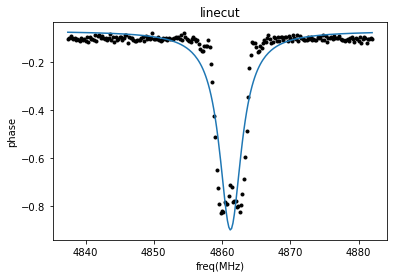

In [21]:
# Fit spectrum

# Find f_q to current data
f_q_list   = np.empty(len(yoko))
kappa_list = np.empty(len(yoko))
plot_detail = False
plot_idx = 7 #len(yoko)-7
for i, line_cut in enumerate(phase.T):
    if i == plot_idx: plot_detail = True
    f_q_list[i], kappa_list[i]  = f_q_fitter(line_cut, freq, plot_detail=plot_detail)
    plot_detail = False

a=3309.9(MHz) b=0.484(1/mA) c=0.590(mA) d=1557.1(MHz)


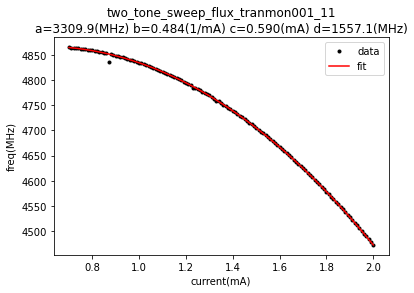

In [22]:
#para_spectrum, _ = CF(curve, np.delete(yoko,[len(yoko)-1,-6,-4,-5]), np.delete(f_q_list,[len(yoko)-1,-6,-4,-5]), p0=[3e+3,0.5,0.6,1e+3], maxfev=100000)
para_spectrum, _ = CF(curve, yoko[2:], f_q_list[2:], p0=[3e+3,0.5,0.6,1e+3], maxfev=100000)
text = "a={:.1f}(MHz) b={:.3f}(1/mA) c={:.3f}(mA) d={:.1f}(MHz)".format(*para_spectrum)
print(text)

file_name = files[test_idx].split("\\")[-1].replace(".hdf5","")
plt.title(file_name + "\n"+text)
plt.xlabel("current(mA)")
plt.ylabel("freq(MHz)")
#plt.plot(np.delete(yoko,[len(yoko)-1,-6,-4,-5]), np.delete(f_q_list,[len(yoko)-1,-6,-4,-5]),"k.")
plt.plot(yoko, f_q_list, "k.", label="data")
plt.plot(yoko, curve(yoko, *para_spectrum), "r-", label="fit")
plt.legend()
#plt.savefig(file_name + ".png")

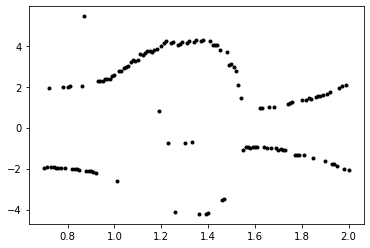

In [23]:
plt.plot(yoko, kappa_list, "k.", label="data")

In [24]:
### fitting function
#   curve = lambda I, a,b,c,d: a*( np.cos( b*(I-c) ) )**0.5 + d
### analytic: Ej~18.8GHz, Ec~0.8GHz
#   (8*Ec*EJ             )**0.5 - Ec
# = (8*Ec*EJmax*cosB(I-C))**0.5 - Ec

### record
### fit failed at some linecut where noise>signal, so select [s:e] to fit
""" a+d: max(f_q), b: ratio of current to flux, c: current offset
                                                            a+d     index of deleted points
2 : a=2818.0(MHz) b=0.519(1/mA) c= 0.575(mA) d=2050.6(MHz)  5623.6
3 : a=3067.5(MHz) b=0.504(1/mA) c= 0.596(mA) d=1800.0(MHz)  4867.5
4 : a=1585.8(MHz) b=0.664(1/mA) c= 0.634(mA) d=3281.1(MHz)  4866.9  [len(yoko)-1, -4, -5, -6]
5 : a=1143.0(MHz) b=0.767(1/mA) c= 0.596(mA) d=3681.3(MHz)  4824.3  [1:]
6 : a=4655.2(MHz) b=0.413(1/mA) c= 0.575(mA) d=209.7(MHz)   4864.9  [:-1]
7 : a=3701.5(MHz) b=0.459(1/mA) c= 0.590(mA) d=1166.0(MHz)  4867.5  [2:]
8 : a=3547.4(MHz) b=0.467(1/mA) c= 0.596(mA) d=1320.3(MHz)  4867.7
9 : a=4856.8(MHz) b=0.408(1/mA) c= 0.551(mA) d=0.8(MHz)     4857.6
12: a=3433.5(MHz) b=1.552(1/mA) c=-0.039(mA) d=1408.8(MHz)  4842.3
13: a=4278.8(MHz) b=1.393(1/mA) c=-0.039(mA) d=563.7(MHz)   4842.5  [:-4]
"""

' a+d: max(f_q), b: ratio of current to flux, c: current offset\n                                                            a+d     index of deleted points\n2 : a=2818.0(MHz) b=0.519(1/mA) c= 0.575(mA) d=2050.6(MHz)  5623.6\n3 : a=3067.5(MHz) b=0.504(1/mA) c= 0.596(mA) d=1800.0(MHz)  4867.5\n4 : a=1585.8(MHz) b=0.664(1/mA) c= 0.634(mA) d=3281.1(MHz)  4866.9  [len(yoko)-1, -4, -5, -6]\n5 : a=1143.0(MHz) b=0.767(1/mA) c= 0.596(mA) d=3681.3(MHz)  4824.3  [1:]\n6 : a=4655.2(MHz) b=0.413(1/mA) c= 0.575(mA) d=209.7(MHz)   4864.9  [:-1]\n7 : a=3701.5(MHz) b=0.459(1/mA) c= 0.590(mA) d=1166.0(MHz)  4867.5  [2:]\n8 : a=3547.4(MHz) b=0.467(1/mA) c= 0.596(mA) d=1320.3(MHz)  4867.7\n9 : a=4856.8(MHz) b=0.408(1/mA) c= 0.551(mA) d=0.8(MHz)     4857.6\n12: a=3433.5(MHz) b=1.552(1/mA) c=-0.039(mA) d=1408.8(MHz)  4842.3\n13: a=4278.8(MHz) b=1.393(1/mA) c=-0.039(mA) d=563.7(MHz)   4842.5  [:-4]\n'

In [25]:
#for i in range(len(data_list)):
#    print(i, files[i].split("\\")[-1].replace(".hdf5",""))
"""
0 EIT_two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_001
1 two_tone_sweep_flux_tranmon001_10
2 two_tone_sweep_flux_tranmon001_11
3 two_tone_sweep_flux_tranmon001_2
4 two_tone_sweep_flux_tranmon001_5(1)
5 two_tone_sweep_flux_tranmon001_5
6 two_tone_sweep_flux_tranmon001_6(1)
7 two_tone_sweep_flux_tranmon001_6
8 two_tone_sweep_flux_tranmon001_7
9 two_tone_sweep_flux_tranmon001_8(1)
10 two_tone_sweep_flux_tranmon001_8
11 two_tone_sweep_flux_tranmon001_9
12 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_003
13 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_004
14 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_005
15 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_006(1)
16 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_006
17 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_007
18 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_008
19 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_009
20 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_010
"""

'\n0 EIT_two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_001\n1 two_tone_sweep_flux_tranmon001_10\n2 two_tone_sweep_flux_tranmon001_11\n3 two_tone_sweep_flux_tranmon001_2\n4 two_tone_sweep_flux_tranmon001_5(1)\n5 two_tone_sweep_flux_tranmon001_5\n6 two_tone_sweep_flux_tranmon001_6(1)\n7 two_tone_sweep_flux_tranmon001_6\n8 two_tone_sweep_flux_tranmon001_7\n9 two_tone_sweep_flux_tranmon001_8(1)\n10 two_tone_sweep_flux_tranmon001_8\n11 two_tone_sweep_flux_tranmon001_9\n12 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_003\n13 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_004\n14 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_005\n15 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_006(1)\n16 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_006\n17 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_007\n18 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_008\n19 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_009\n20 two_tone_transmon001_in_6.55GHz_cavity_sweep_flux_010\n'

In [26]:
#a = np.array([2818.0, 3067.5, 1585.8, 1143.0, 4655.2, 3701.5, 3547.4, 4856.8, 3433.5, 4278.8])
#d = np.array([2805.6, 1800.0, 3281.1, 3681.3, 0209.7, 1166.0, 1320.3, 0000.8, 1408.8, 0563.7])
#print(a+d) #[5623.6 4867.5 4866.9 4824.3 4864.9 4867.5 4867.7 4857.6 4842.3 4842.5]